# A molecular single-cell lung atlas of lethal COVID-19

The Dataset was downloaded from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE171524
Download the GSE171524_RAW.tar file and save it for instance in a folder called raw. 

In [2]:
# Packages to install (if not available yet, remove ##):
## !pip install scanpy
##!pip install scvi-tools
##!pip install --upgrade pip
##!pip install scikit-misc #required for 'seurat_v3' option in scanpy
##!pip install leidenalg

In [1]:
#Import of packages
import scanpy as sc
import scvi
from scipy.sparse import csr_matrix

/Users/thorsten/.pyenv/versions/3.10.6/envs/Bioinformatics/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/Users/thorsten/.pyenv/versions/3.10.6/envs/Bioinformatics/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/Users/thorsten/.pyenv/versions/3.10.6/envs/Bioinformatics/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/Users/thorsten/.pyenv/versions/3.10.6/envs/Bioinformatics/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/Users/tho

In [16]:
# Import the read file (in this case csv file but can also be an h5 or other file formats). Use sc.read and Tab to see the possiblities for scanpy.
adata = sc.read_csv('/GSE171524_RAW/GSM5226574_C51ctr_raw_counts.csv.gz').T

In [3]:
adata # shows what adata is

AnnData object with n_obs × n_vars = 6099 × 34546

# AnnData Format
The variable adata is an Anndata format (https://anndata.readthedocs.io/en/latest/tutorials/notebooks/getting-started.html) and consist of three components:
 - adata.obs
 - adata.var 
 - adata.X
 
 adata.obs contains the cell barcodes (later additional observations are added to this dataframe)<br>
 adata.var contains the GeneNames <br>
 adata.X is the matrix with the read counts
 
 Let's get a feeling for the data. In python we can use different functions to check the dataframe/matrix and get a quick **overview** of its structure.<br>
 
 
 - .shape &rarr; shows the number of rows and columns (rows, columns) in a dataframe
 - .dtype &rarr; shows the datatype of each column (float, integer, string, object). In single cell data this works in the beginning only on the adata.X! 
 - .info &rarr; give general infos on the dataframe including column names, non-null values, and dtypes
 - .describe() &rarr; summary of numeric columns (Count, mean, std, min, 25%, 50%, 75%, max) <br>
 
 
 **Column or indices can be accessed by using:**  <br>
 - .columns &rarr; shows the column names if there is a header
 - .index &rarr; shows the indices of the dataframe <br>
 
 Below we will only show the shape but try the other commands too:)

In [4]:
adata.obs.shape

(6099, 0)

In [5]:
adata.var.shape

(34546, 0)

In [6]:
adata.X # this is a numpy array!
adata.X.shape

(6099, 34546)

# Doublet Removal 

This used scvi to remove doublets (see how to import above) and scanpy (sc) to modify the dataframes

In [7]:
adata

AnnData object with n_obs × n_vars = 6099 × 34546

In [8]:
Total_Number_of_genes = adata.shape[1]
Total_Number_of_genes

34546

In [9]:
# Keeps only genes that are found in at least 10 cells
sc.pp.filter_genes(adata, min_cells = 10)

In [10]:
adata

AnnData object with n_obs × n_vars = 6099 × 19896
    var: 'n_cells'

In [11]:
Number_of_genes_filtered = adata.shape[1]
Number_of_genes_filtered

19896

In [12]:
# Small Calculation on how much percent of genes are lost
Loss_of_genes = ((Total_Number_of_genes-Number_of_genes_filtered)/Total_Number_of_genes)*100
Loss_of_genes

42.407225149076595

In [13]:
# Subset the top 2000 genes of the dataset to train the scvi model (to be quicker and it is sufficient training material)
sc.pp.highly_variable_genes(adata, n_top_genes = 2000, subset = True, flavor = 'seurat_v3')

In [14]:
# Check if subsetting worked
adata

AnnData object with n_obs × n_vars = 6099 × 2000
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'

In [15]:
# Train the SCVI Model
scvi.model.SCVI.setup_anndata(adata)
vae = scvi.model.SCVI(adata)
vae.train()

/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


In [16]:
# Train the doublet class model (it has an stop inside if loss is not changing anymore)
solo = scvi.external.SOLO.from_scvi_model(vae)
solo.train()

INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.288. Signaling Trainer to stop.


In [17]:
# Use predict to annotate the cell barcodes with the trained identifier and annotate it as a string in "doublet" or "singlet"
df = solo.predict()
df['prediction'] = solo.predict(soft=False)
df

/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)


,doublet,singlet,prediction
TAGGTACCATGGCCAC-1_1,0.806161,0.193839,doublet
ATTCACTGTAACAGGC-1_1,0.896878,0.103122,doublet
TAACTTCCAACCACGC-1_1,0.639890,0.360110,doublet
TTGGGTACACGACAAG-1_1,0.728426,0.271574,doublet
AGGCCACAGAGTCACG-1_1,0.791725,0.208275,doublet
...,...,...,...
CGCCATTGTTTGCCGG-1_1,0.033506,0.966494,singlet
CACTGGGGTCTACGTA-1_1,0.001865,0.998135,singlet
CATACTTGTAGAGGAA-1_1,0.007503,0.992497,singlet
TTTGGTTTCCACGGAC-1_1,0.002731,0.997269,singlet


In [18]:
# Check how much cells are lost (close to 20%)
df.groupby('prediction').count()

,doublet,singlet
prediction,,
doublet,1122,1122
singlet,4977,4977


In [39]:
#Calculating the difference of doublet and singlet score to identify cells that have high scores in both (close to 0)
df['dif'] = df.doublet - df.singlet
df

,doublet,singlet,prediction,dif
TAGGTACCATGGCCAC-1_1,0.806161,0.193839,doublet,0.612323
ATTCACTGTAACAGGC-1_1,0.896878,0.103122,doublet,0.793757
TAACTTCCAACCACGC-1_1,0.639890,0.360110,doublet,0.279781
TTGGGTACACGACAAG-1_1,0.728426,0.271574,doublet,0.456851
AGGCCACAGAGTCACG-1_1,0.791725,0.208275,doublet,0.583451
...,...,...,...,...
CGCCATTGTTTGCCGG-1_1,0.033506,0.966494,singlet,-0.932988
CACTGGGGTCTACGTA-1_1,0.001865,0.998135,singlet,-0.996270
CATACTTGTAGAGGAA-1_1,0.007503,0.992497,singlet,-0.984994
TTTGGTTTCCACGGAC-1_1,0.002731,0.997269,singlet,-0.994538


In [20]:
import seaborn as sns

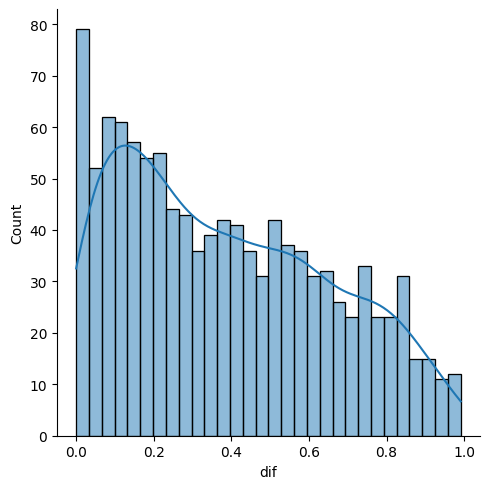

In [24]:
#Use seaborn to show histogram of dif and decide emperically a cutoff
sns.displot(df[df.prediction == 'doublet'], x= 'dif', bins=30, kde=True)

In [50]:
# Generate a list containing only filtered doublet cells (to not loose to much data)
doublets = df[(df['prediction'] == 'doublet') & (df.dif > 0.42)]
doublets

,doublet,singlet,prediction,dif
TAGGTACCATGGCCAC-1_1,0.806161,0.193839,doublet,0.612323
ATTCACTGTAACAGGC-1_1,0.896878,0.103122,doublet,0.793757
TTGGGTACACGACAAG-1_1,0.728426,0.271574,doublet,0.456851
AGGCCACAGAGTCACG-1_1,0.791725,0.208275,doublet,0.583451
CACTGAAGTCGAAGCA-1_1,0.731615,0.268385,doublet,0.463231
...,...,...,...,...
CAATACGCAATGTGGG-1_1,0.716351,0.283649,doublet,0.432701
AAAGAACGTACACTCA-1_1,0.935838,0.064162,doublet,0.871677
GGGCTACTCGTGCAGC-1_1,0.729028,0.270972,doublet,0.458057
ATCAGGTGTCGTCTCT-1_1,0.840900,0.159100,doublet,0.681800


In [51]:
# Reload adata and annotate doublet annotation on all barcodes/cells (before we filtered out already many cells to train the model!)
adata = sc.read_csv('/GSE171524_RAW/GSM5226574_C51ctr_raw_counts.csv.gz').T
# This annotates the cells with True/false True = doublet, false = singlet
adata.obs['doublet'] = adata.obs.index.isin(doublets.index)
adata.obs

,doublet
TAGGTACCATGGCCAC-1_1,True
ATTCACTGTAACAGGC-1_1,True
TAACTTCCAACCACGC-1_1,False
TTGGGTACACGACAAG-1_1,True
AGGCCACAGAGTCACG-1_1,True
...,...
CGCCATTGTTTGCCGG-1_1,False
CACTGGGGTCTACGTA-1_1,False
CATACTTGTAGAGGAA-1_1,False
TTTGGTTTCCACGGAC-1_1,False


In [52]:
# Filter adata for singlets (~ means you keep the false which are the singlets)
adata = adata[~adata.obs.doublet]
# Check how many cells are left over
adata

View of AnnData object with n_obs × n_vars = 5634 × 34546
    obs: 'doublet'

# Preprocessing

In [53]:
#Filter adata.var for removal of MT genes 
adata.var['mt'] = adata.var[adata.var.index.str.startswith('MT-')]

""
AL627309.1
AL627309.5
AL627309.4
AL669831.2
LINC01409
...
VN1R2
AL031676.1
SMIM34A
AL050402.1


In [64]:
#Using boolean series to assign if mitochondrial gene or not to adata.var dataframe
adata.var['mt'] = adata.var.index.str.startswith('MT-')

/var/folders/vn/wdw36m4d5k13n07b5xlhgmsr0000gn/T/ipykernel_45124/310233584.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['mt'] = adata.var.index.str.startswith('MT-')


In [65]:
adata.var

,mt
AL627309.1,False
AL627309.5,False
AL627309.4,False
AL669831.2,False
LINC01409,False
...,...
VN1R2,False
AL031676.1,False
SMIM34A,False
AL050402.1,False


Next we annotated the ribosomal genes. 

In [23]:
import pandas as pd

In [24]:

ribo_url = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt"


In [25]:
ribo_genes = pd.read_table(ribo_url, skiprows=2, header=None)
ribo_genes

,0
0,FAU
1,MRPL13
2,RPL10
3,RPL10A
4,RPL10L
...,...
83,RPS9
84,RPSA
85,RSL24D1
86,RSL24D1P11


In [77]:
adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)

In [78]:
adata.var

,mt,ribo
AL627309.1,False,False
AL627309.5,False,False
AL627309.4,False,False
AL669831.2,False,False
LINC01409,False,False
...,...,...
VN1R2,False,False
AL031676.1,False,False
SMIM34A,False,False
AL050402.1,False,False


In [79]:
# Calculate statistic for ribosomal, mitochondrial, UMI number and genes per cell (in adata.var and adata.obs)
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo'], percent_top=None, log1p=False, inplace=True)

In [80]:
adata.var

,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
AL627309.1,False,False,6,0.001065,99.893504,6.0
AL627309.5,False,False,26,0.004615,99.538516,26.0
AL627309.4,False,False,3,0.000532,99.946752,3.0
AL669831.2,False,False,2,0.000355,99.964501,2.0
LINC01409,False,False,231,0.044373,95.899894,250.0
...,...,...,...,...,...,...
VN1R2,False,False,0,0.000000,100.000000,0.0
AL031676.1,False,False,0,0.000000,100.000000,0.0
SMIM34A,False,False,0,0.000000,100.000000,0.0
AL050402.1,False,False,0,0.000000,100.000000,0.0


In [81]:
adata.obs

,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
TAACTTCCAACCACGC-1_1,False,5158,15645.0,221.0,1.412592,211.0,1.348674
TTGGTTTTCCTAGCTC-1_1,False,3902,11472.0,463.0,4.035913,13.0,0.113319
CGCATAACATGCCGGT-1_1,False,3745,8617.0,119.0,1.380991,25.0,0.290124
TCTATCACAAGGCTTT-1_1,False,3582,8276.0,183.0,2.211213,5.0,0.060416
CACTTCGCAGTACTAC-1_1,False,3244,8059.0,253.0,3.139347,14.0,0.173719
...,...,...,...,...,...,...,...
CGCCATTGTTTGCCGG-1_1,False,355,410.0,3.0,0.731707,0.0,0.000000
CACTGGGGTCTACGTA-1_1,False,346,403.0,0.0,0.000000,0.0,0.000000
CATACTTGTAGAGGAA-1_1,False,360,410.0,2.0,0.487805,0.0,0.000000
TTTGGTTTCCACGGAC-1_1,False,299,405.0,0.0,0.000000,2.0,0.493827


In [82]:
# Before filtering table includes genes not occuring in cells
adata.var.sort_values('n_cells_by_counts')

,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
AL445072.1,False,False,0,0.000000,100.000000,0.0
AC092958.4,False,False,0,0.000000,100.000000,0.0
AC092994.1,False,False,0,0.000000,100.000000,0.0
C3orf80,False,False,0,0.000000,100.000000,0.0
AC026316.2,False,False,0,0.000000,100.000000,0.0
...,...,...,...,...,...,...
AKAP13,False,False,4034,2.814696,28.399006,15858.0
MBNL1,False,False,4126,2.668974,26.766063,15037.0
NEAT1,False,False,4135,4.908591,26.606319,27655.0
ZBTB20,False,False,4270,2.399006,24.210153,13516.0


In [83]:
#Filtering genes to be detected at least in 3 cells
sc.pp.filter_genes(adata, min_cells=3)

In [84]:
# after filtering each gene occurs at least in 3 cells
adata.var.sort_values('n_cells_by_counts')

,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells
LINC02478,False,False,3,0.000532,99.946752,3.0,3
AL358333.1,False,False,3,0.000532,99.946752,3.0,3
AL139317.3,False,False,3,0.000532,99.946752,3.0,3
SH3TC2-DT,False,False,3,0.000532,99.946752,3.0,3
TBPL2,False,False,3,0.000532,99.946752,3.0,3
...,...,...,...,...,...,...,...
AKAP13,False,False,4034,2.814696,28.399006,15858.0,4034
MBNL1,False,False,4126,2.668974,26.766063,15037.0,4126
NEAT1,False,False,4135,4.908591,26.606319,27655.0,4135
ZBTB20,False,False,4270,2.399006,24.210153,13516.0,4270


In [87]:

adata.obs.sort_values('total_counts')

,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,n_genes
TGGTACAGTTGGTGTT-1_1,False,323,401.0,0.0,0.000000,0.0,0.000000,323
CGAGAAGGTGAACTAA-1_1,False,308,401.0,0.0,0.000000,0.0,0.000000,307
CAGGGCTTCATGCGGC-1_1,False,330,401.0,7.0,1.745636,1.0,0.249377,330
AGGCATTCATCCGTTC-1_1,False,290,401.0,1.0,0.249377,0.0,0.000000,290
GTCGTTCTCCAAGGGA-1_1,False,300,401.0,0.0,0.000000,0.0,0.000000,299
...,...,...,...,...,...,...,...,...
CACTTCGCAGTACTAC-1_1,False,3244,8059.0,253.0,3.139347,14.0,0.173719,3242
TCTATCACAAGGCTTT-1_1,False,3582,8276.0,183.0,2.211213,5.0,0.060416,3575
CGCATAACATGCCGGT-1_1,False,3745,8617.0,119.0,1.380991,25.0,0.290124,3729
TTGGTTTTCCTAGCTC-1_1,False,3902,11472.0,463.0,4.035913,13.0,0.113319,3897


The authors of this paper have already filtered the cells for a minimum count of 400 but if they would have not we would filter the cells to have a minimum number of read counts like following: 

In [86]:
# sc.pp.filter_cells(adata, min_genes=200) # the 200 is arbitrary based on data

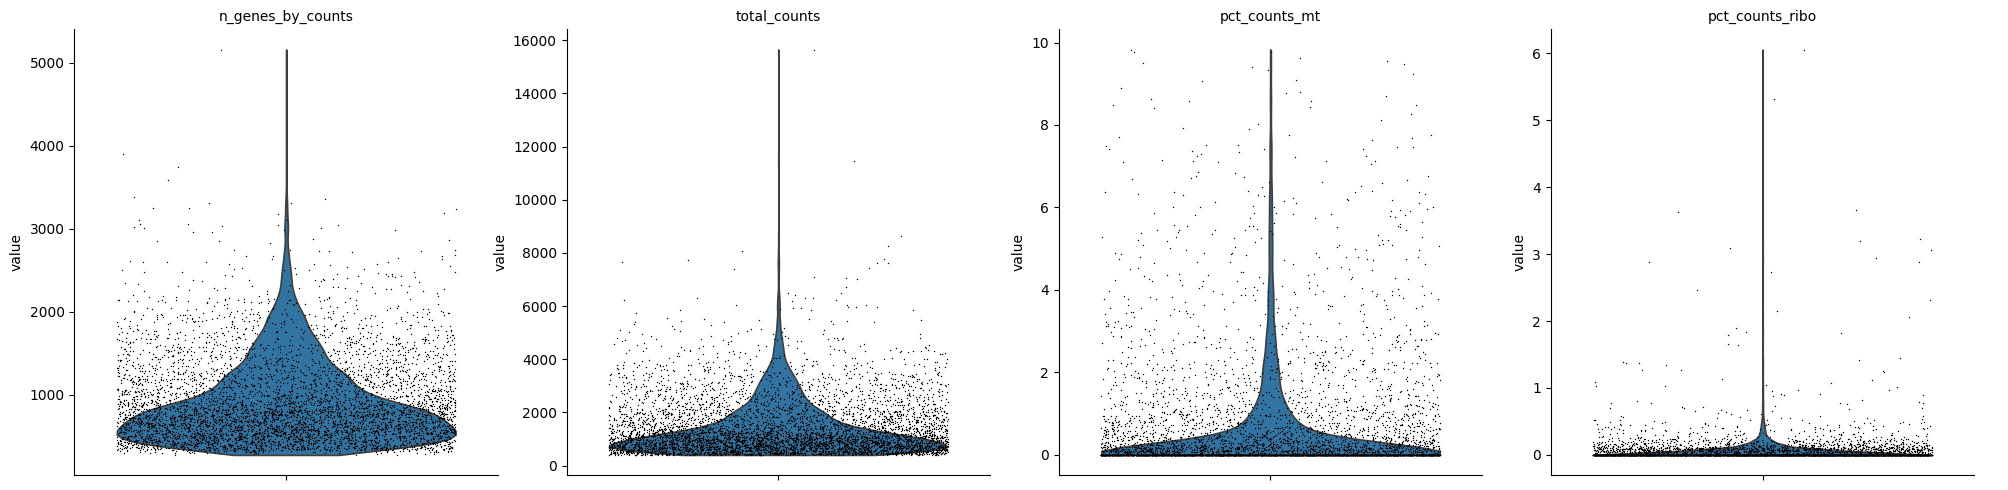

In [88]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'],
             jitter = 0.4, multi_panel = True)

We use these QC metrics to remove outliers. For instance if a cell still has more genes_by_counts or total_counts (these two are highly correlated) than the average cell population this strongly indicates an artifact. Since those two are corrleated we filter by one metric only. Furthermore we will also exclude cells with too high mitochondrial percentage which indicates sequencing artifacts or that the cell is dying. Typically people filters between 5-20% of MT out. Ribosomal reads are also a quality control. High percentage of ribosomal reads indicates low-quality cells (mRNA degradation and therefore rRNA dominates), low RNA complexity (cell contains mainly houskeeping transcripts) and if ambient RNA is present (due to lysed cells) rRNA can make up larger proportions. 

In [26]:
import numpy as np

In [90]:
# Determines the 98th percentile using Numpy to be more objective and not only set a limit by watching the graph.
upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)

In [91]:
upper_lim

2256.0

In [92]:
# Fitler adata to contain only cells having less genes than the upper limit
adata = adata[adata.obs.n_genes_by_counts < upper_lim]

In [94]:
adata.obs

,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,n_genes
ATACTTCCAAGGTCTT-1_1,False,2122,5252.0,1.0,0.019040,4.0,0.076161,2120
TCATGCCGTCTTTCAT-1_1,False,2234,4993.0,0.0,0.000000,3.0,0.060084,2229
GATAGCTCAGGCTTGC-1_1,False,2167,4879.0,0.0,0.000000,0.0,0.000000,2166
TACATTCGTACGTACT-1_1,False,2253,4776.0,13.0,0.272194,1.0,0.020938,2250
GACCCAGCACCCTATC-1_1,False,2150,4784.0,28.0,0.585284,4.0,0.083612,2149
...,...,...,...,...,...,...,...,...
CGCCATTGTTTGCCGG-1_1,False,355,410.0,3.0,0.731707,0.0,0.000000,355
CACTGGGGTCTACGTA-1_1,False,346,403.0,0.0,0.000000,0.0,0.000000,346
CATACTTGTAGAGGAA-1_1,False,360,410.0,2.0,0.487805,0.0,0.000000,360
TTTGGTTTCCACGGAC-1_1,False,299,405.0,0.0,0.000000,2.0,0.493827,299


In [96]:
# Next filter the mitochondria on 20% 
adata = adata[adata.obs.pct_counts_mt < 20]

In [97]:
# Filter on ribosomal percentage 
adata = adata[adata.obs.pct_counts_ribo < 2]

In [98]:
adata

View of AnnData object with n_obs × n_vars = 5504 × 24121
    obs: 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

# Normalization

In adata X each row is a cell and each column is a gene

In [100]:
# Showing that each cell has a different number of total counts
adata.X.sum(axis=1)

array([5250., 4988., 4878., ...,  410.,  405.,  410.], dtype=float32)

Normalization includes to normalize the counts of each cell so that the total counts adds up to the same value.

In [102]:
sc.pp.normalize_total(adata, target_sum=1e4) #normalize to 10000 UMIs

/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [103]:
# After normalization the total counts of each cell is the same!
adata.X.sum(axis=1)

array([10000., 10000., 10000., ..., 10000., 10000., 10000.], dtype=float32)

In [104]:
# Change to log counts
sc.pp.log1p(adata)

In [105]:
adata.X.sum(axis=1)

array([2858.1602, 3191.3232, 3131.851 , ..., 1191.2706, 1022.7512,
       1162.8784], dtype=float32)

**!!! Important !!!*** Now it is very important to freeze the data as it is now. Before we do further start filtering out genes, regressing data or scale data. 
For this we safe it in the raw slot of the adata format. 

In [106]:
adata.raw = adata
#Lot of functions later will actually use the raw data!

# Clustering

In [107]:
#Adds statistic about variability of gene expression into adata.var
sc.pp.highly_variable_genes(adata, n_top_genes = 2000)

In [109]:
adata.var

,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells,highly_variable,means,dispersions,dispersions_norm
AL627309.1,False,False,6,0.001065,99.893504,6.0,6,True,0.010376,2.815590,1.415001
AL627309.5,False,False,26,0.004615,99.538516,26.0,26,False,0.029318,2.300095,-0.164139
AL627309.4,False,False,3,0.000532,99.946752,3.0,3,False,0.002524,1.702826,-1.993777
LINC01409,False,False,231,0.044373,95.899894,250.0,231,False,0.265627,2.331154,-0.068994
FAM87B,False,False,6,0.001065,99.893504,6.0,6,False,0.007235,1.947622,-1.243883
...,...,...,...,...,...,...,...,...,...,...,...
AL354822.1,False,False,116,0.020944,97.941072,118.0,116,False,0.154065,2.424779,0.217811
AL592183.1,False,False,858,0.179801,84.771033,1013.0,858,False,0.872996,2.513105,-0.404280
AC240274.1,False,False,139,0.025204,97.532836,142.0,139,False,0.150549,2.312172,-0.127142
AC007325.4,False,False,4,0.000710,99.929002,4.0,4,False,0.003033,1.579870,-2.370433


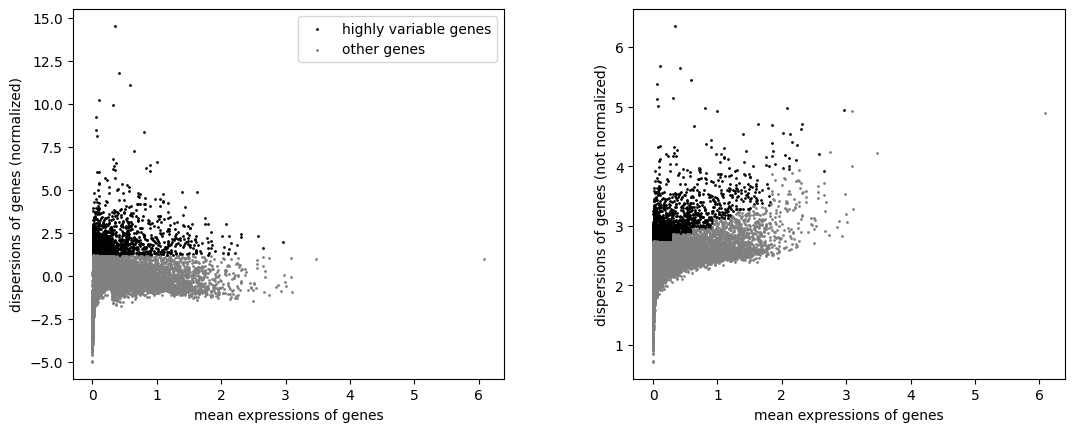

In [110]:
sc.pl.highly_variable_genes(adata)

In [111]:
# Filter to only keep the highly variable genes, non of this touches the raw data we saved earlier
adata = adata[:,adata.var.highly_variable]

In [113]:
# We regress out differences that arise due to total counts, pct_counts_mt, pct_counts_ribo. 
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt', 'pct_counts_ribo'])

/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:729: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:667: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 2, 'C', False, aligned=True))
  data[i] -= regressor[i] @ coeff
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:667: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 2, 'C', False, aligned=True))
  data[i] -= regressor[i] @ coeff
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [114]:
sc.pp.scale(adata, max_value=10)

In [117]:
sc.tl.pca(adata, svd_solver='arpack')

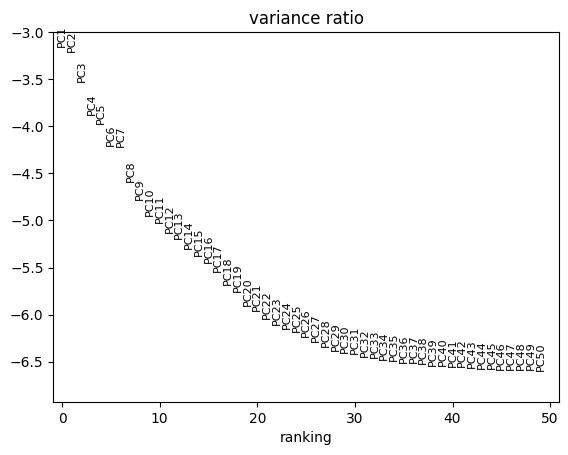

In [119]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=50)
# Find the ellbow

In [120]:
# Calculate the neighbors of the cells using the Top30 PCAs.
sc.pp.neighbors(adata, n_pcs = 30)

How to look into the "neighbors" (cell by cell matrix, if they are connected they have a value in connectivities, 
and each of the connected cells will also have a distance. Below how to see the matrix (remove # to run it)

In [125]:
# adata.obsp['connectivities'].toarray()
# adata.obsp['distances'].toarray()

array([[0.        , 3.98042417, 4.91456842, ..., 0.        , 0.        ,
        0.        ],
       [3.98042417, 0.        , 3.33684683, ..., 0.        , 0.        ,
        0.        ],
       [4.91456842, 3.33684683, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

This neighborhood matrices are used for clustering. 

In [159]:
sc.tl.umap(adata)

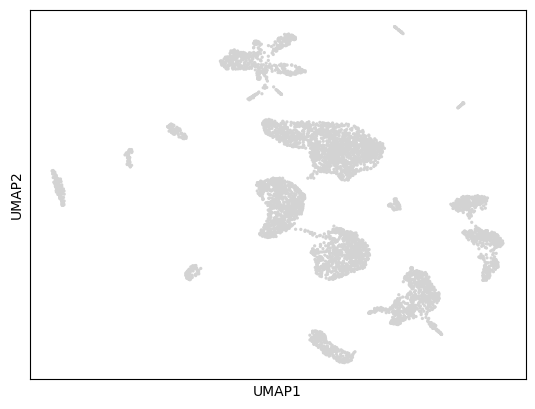

In [160]:
sc.pl.umap(adata)

In [165]:
sc.tl.leiden(adata, resolution=0.3, key_added='leiden_fc', flavor="igraph", n_iterations=1)

In [166]:
adata.obs

,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,n_genes,leiden,leiden_fc
ATACTTCCAAGGTCTT-1_1,False,2122,5252.0,1.0,0.019040,4.0,0.076161,2120,0,0
TCATGCCGTCTTTCAT-1_1,False,2234,4993.0,0.0,0.000000,3.0,0.060084,2229,0,0
GATAGCTCAGGCTTGC-1_1,False,2167,4879.0,0.0,0.000000,0.0,0.000000,2166,0,0
TACATTCGTACGTACT-1_1,False,2253,4776.0,13.0,0.272194,1.0,0.020938,2250,1,1
GACCCAGCACCCTATC-1_1,False,2150,4784.0,28.0,0.585284,4.0,0.083612,2149,0,0
...,...,...,...,...,...,...,...,...,...,...
CGCCATTGTTTGCCGG-1_1,False,355,410.0,3.0,0.731707,0.0,0.000000,355,1,1
CACTGGGGTCTACGTA-1_1,False,346,403.0,0.0,0.000000,0.0,0.000000,346,2,2
CATACTTGTAGAGGAA-1_1,False,360,410.0,2.0,0.487805,0.0,0.000000,360,12,12
TTTGGTTTCCACGGAC-1_1,False,299,405.0,0.0,0.000000,2.0,0.493827,299,7,7


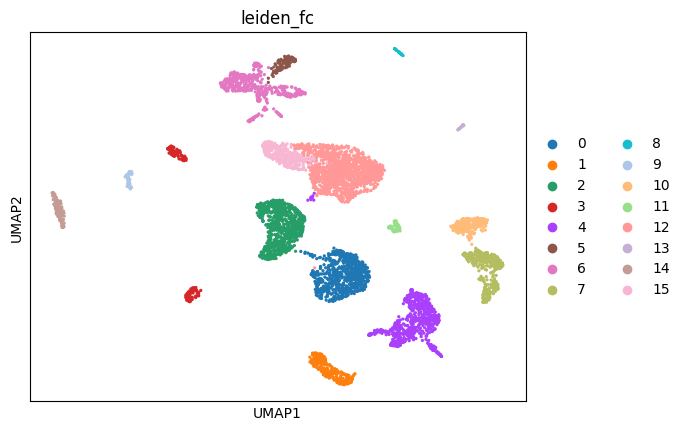

In [167]:
sc.pl.umap(adata, color=['leiden_fc'])

# Integration of multiple samples (above  was only one!)

In [27]:
# Function for preprocessing of each sample
def preprocessing(csv_path):
    adata = sc.read_csv(csv_path).T
    # Fitler genes to be expressed at least in 10 cells
    sc.pp.filter_genes(adata, min_cells = 10)
    #Subsetting for doublet removal the 2000 top-variable genes)
    sc.pp.highly_variable_genes(adata, n_top_genes = 2000, subset = True, flavor = 'seurat_v3')
    #SCVI model for doublet removal
    scvi.model.SCVI.setup_anndata(adata)
    vae = scvi.model.SCVI(adata)
    vae.train()
    solo = scvi.external.SOLO.from_scvi_model(vae)
    solo.train()
    df = solo.predict()
    df['prediction'] = solo.predict(soft = False)
    #df.index = df.index.map(lambda x: x[:-2])
    df['dif'] = df.doublet - df.singlet
    doublets = df[(df.prediction == 'doublet') & (df.dif > 0.42)]
    
    adata = sc.read_csv(csv_path).T
    adata.obs['Sample'] = csv_path.split('_')[2] #'raw_counts/GSM5226574_C51ctr_raw_counts.csv'
    
    adata.obs['doublet'] = adata.obs.index.isin(doublets.index)
    adata = adata[~adata.obs.doublet]
    
    
    sc.pp.filter_cells(adata, min_genes=200) #get rid of cells with fewer than 200 genes
    #sc.pp.filter_genes(adata, min_cells=3) #get rid of genes that are found in fewer than 3 cells
    adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
    adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)
    upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
    adata = adata[adata.obs.n_genes_by_counts < upper_lim]
    adata = adata[adata.obs.pct_counts_mt < 20]
    adata = adata[adata.obs.pct_counts_ribo < 2]
    adata.X = csr_matrix(adata.X)

    return adata

In [28]:
import os

In [29]:
out = []
for f in [file for file in os.listdir('./') if file.endswith ('.csv.gz')]:    
    out.append(preprocessing('./' + f))


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.199. Signaling Trainer to stop.


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning: Trying

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.287. Signaling Trainer to stop.


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning: Trying

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.261. Signaling Trainer to stop.


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning: Trying

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.312. Signaling Trainer to stop.


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning: Trying

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.317. Signaling Trainer to stop.


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning: Trying

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.194. Signaling Trainer to stop.


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning: Trying

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.363. Signaling Trainer to stop.


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning: Trying

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.237. Signaling Trainer to stop.


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning: Trying

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.274. Signaling Trainer to stop.


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning: Trying

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.279. Signaling Trainer to stop.


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning: Trying

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.311. Signaling Trainer to stop.


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning: Trying

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.344. Signaling Trainer to stop.


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning: Trying

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.299. Signaling Trainer to stop.


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning: Trying

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.289. Signaling Trainer to stop.


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning: Trying

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.320. Signaling Trainer to stop.


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning: Trying

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.286. Signaling Trainer to stop.


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning: Trying

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.182. Signaling Trainer to stop.


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning: Trying

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.212. Signaling Trainer to stop.


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning: Trying

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.248. Signaling Trainer to stop.


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning: Trying

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.293. Signaling Trainer to stop.


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning: Trying

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.328. Signaling Trainer to stop.


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning: Trying

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.341. Signaling Trainer to stop.


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning: Trying

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.305. Signaling Trainer to stop.


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning: Trying

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.270. Signaling Trainer to stop.


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning: Trying

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.313. Signaling Trainer to stop.


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning: Trying

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.246. Signaling Trainer to stop.


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning: Trying

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.262. Signaling Trainer to stop.


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning: Trying

⚠️ Memory Warning (SCVI Training)

    Note: Training SCVI models, especially during data concatenation or preprocessing, can be very memory-intensive. On a typical laptop setup (e.g., MacBook), this step often causes the Jupyter kernel to crash due to insufficient RAM. Running this pipeline on a machine with larger memory resources (e.g., a workstation or cloud VM) is highly recommended.

To avoid the hassle of reinstalling dependencies or configuring Python environments on another machine, this repository includes a **Docker setup**. Simply use the provided Dockerfile to replicate the environment on any compatible system. How to run the docker: 

1.) Move the files (Dockerfile, requirements.txt, SCVI_Model_Training_Concatenation.py) in the Docker directory,   into the folder where youre have your directory named **raw_counts** which contain the raw counts of the single cell dataset. <br>
2.) Change the directory in your terminal to the same location. <br>
3.) Build the Docker by running: **docker build -t scvimodel .** <br>
4.) When the image was build run the Docker with: run --rm -v $(pwd):/app scvimodel 

**Note:** that the SCVI_Model_Training_Concatenation.py script is adapted to this dataset (mt, ribo cutoffs, nameing of files etc). If you use it for a different dataset make sure to change the parameters to your setting!


In [ ]:
# adata = sc.concat(out)

In [2]:
import scanpy as sc
import scvi
import seaborn as sns
import numpy as np
import pandas as pd

In [4]:
adata = sc.read_h5ad('TK_SCA_combined.h5ad')
adata

AnnData object with n_obs × n_vars = 108822 × 29581
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'n_cells'

In [5]:
adata.X

<108822x29581 sparse matrix of type '<class 'numpy.float32'>'
	with 95760461 stored elements in Compressed Sparse Row format>

In [6]:
#Check how many cells per sample by groupby count
adata.obs.groupby('Sample').count()

/var/folders/vn/wdw36m4d5k13n07b5xlhgmsr0000gn/T/ipykernel_91305/68267705.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby('Sample').count()


,doublet,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
Sample,,,,,,,,
C51ctr,5960,5960,5960,5960,5960,5960,5960,5960
C52ctr,4415,4415,4415,4415,4415,4415,4415,4415
C53ctr,6928,6928,6928,6928,6928,6928,6928,6928
C54ctr,4284,4284,4284,4284,4284,4284,4284,4284
C55ctr,5565,5565,5565,5565,5565,5565,5565,5565
C56ctr,3904,3904,3904,3904,3904,3904,3904,3904
C57ctr,4687,4687,4687,4687,4687,4687,4687,4687
L01cov,2952,2952,2952,2952,2952,2952,2952,2952
L03cov,3953,3953,3953,3953,3953,3953,3953,3953


In [7]:
# Since we still have ~29K genes, to and over 100K cells so we can take strikter rules to keep 
# only genes that occur at least in 100 cells.
sc.pp.filter_genes(adata, min_cells = 100)

In [8]:
adata

AnnData object with n_obs × n_vars = 108822 × 21306
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'n_cells'

This is the integration of the data. Although the data is combined now, the actual integration is just starting. We still need to take care of batch effects (since the data might be from different batches, conditions or experiments) and also again remove artifacts and dead cells (pct_counts_mt, pct_counts_ribo). There are several ways to integrate data. We will use the deep-learning driven scVI. However other methods are:  
- scVI/scArches (Deep Learning based models)
- Harmony (faster than scVI)
- Scanorama (alterntive to scVI in python)
- Batch balanced k-nearest neighbor (BBKNN)

However, before we do the integration we save the raw data (not normalized, not converted to log or anything!). 

In [9]:
adata.layers['counts'] = adata.X.copy() #scVI will use this counts layer

In [10]:
# a lot of other functions will use this raw data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

In [11]:
adata.obs.head(5)

,Sample,doublet,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
CTCCAACCATACACCA-1_7,C57ctr,False,1812,1812,3962.0,0.0,0.0,1.0,0.025240
TACTTACTCCATACTT-1_7,C57ctr,False,1845,1845,3643.0,0.0,0.0,1.0,0.027450
CCTCCAAGTGACATCT-1_7,C57ctr,False,1864,1864,3438.0,0.0,0.0,10.0,0.290867
GACTTCCAGACAACTA-1_7,C57ctr,False,1827,1827,3406.0,0.0,0.0,0.0,0.000000
CAACGATGTTGCTCAA-1_7,C57ctr,False,1845,1845,3405.0,0.0,0.0,0.0,0.000000


You're number of genes should be at least 1/2 to 1/3 of your number of cells (if you have 10 000 cells genes should be maximum 3000). If you have more than run the following to reduce the number of genes further! We have around 100K cells here for 20K genes, so we don't run it. 

In [12]:
# sc.pp.highly_variable_genes(adata, n_top_genes=3000, subset=True, layer = 'counts', flavor='seurat_v3', batch_key='Sample') #no batch key if you only have one sample

In [13]:
# Now we train the integration model for batch correction, mitochondrial, total and ribo counts correction using scvi:
scvi.model.SCVI.setup_anndata(adata, layer = 'counts',
                             categorical_covariate_keys= ['Sample'], # if one has multiple batches or sequencing technologies those can be added here as e.g. ,['batch']
                             continuous_covariate_keys= ['pct_counts_mt', 'total_counts','pct_counts_ribo'])

In [14]:
model = scvi.model.SCVI(adata)

In [15]:
model.train()

/Users/thorsten/.pyenv/versions/3.10.6/envs/Bioinformatics/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/thorsten/.pyenv/versions/3.10.6/envs/Bioinformatics/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/thorsten/.pyenv/versions/3.10.6/envs/Bioinformatics/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the v

Training:   0%|          | 0/74 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=74` reached.


⚠️ Warning: <br>
After training, all model weights and the AnnData object containing your 100K cells are stored in memory. Subsequent steps may take some time, especially on a standard MacBook, so please be patient. To avoid losing progress in case the notebook kernel crashes, it is highly **recommended to save the trained model**. This way, you can simply reload them without needing to retrain the model.

In [16]:
#This saves the model in your directory under "integrated_model.pt"
model.save('Integrated_model',overwrite=True)

In [ ]:
#If you need to reload:
from scvi.model import SCVI
model = SCVI.load('Integrated_model', adata)
# if the kernel crashed you need to reload also your adata and run all steps before the model setup and training!

In [17]:
# It is a numpy array with the number of rows equals the cells and 10 columns
model.get_latent_representation().shape

(108822, 10)

In [18]:
# We store it in adata.obsm named as "X_scVI" 
adata.obsm['X_scVI'] = model.get_latent_representation()

In [23]:
#Scvi normalized expression is a cell by gene dataframe
model.get_normalized_expression(library_size = 1e4)

,AL627309.1,AL627309.5,LINC01409,LINC01128,LINC00115,AL645608.6,AL645608.2,LINC02593,SAMD11,NOC2L,...,MT1A,IGSF5,AC244213.1,DDX3Y,NLGN4Y,AC011751.1,AC010889.1,AC010889.2,CCL7,TFF2
CTCCAACCATACACCA-1_7,0.021409,0.069072,0.117206,0.031886,0.007379,0.003995,0.001766,0.009311,0.022086,0.057813,...,0.005328,0.001194,0.076784,0.440496,0.560820,0.002579,0.052707,0.026447,0.000469,0.000318
TACTTACTCCATACTT-1_7,0.029427,0.110464,0.224376,0.045439,0.011399,0.007446,0.002560,0.013526,0.045429,0.073541,...,0.007450,0.001669,0.107509,0.674842,1.085181,0.004894,0.109322,0.062029,0.001235,0.000615
CCTCCAAGTGACATCT-1_7,0.017359,0.043527,0.204152,0.062233,0.006795,0.007614,0.005600,0.001640,0.030338,0.210175,...,0.007013,0.002705,0.053542,0.609725,0.175979,0.006703,0.015448,0.003874,0.006331,0.010257
GACTTCCAGACAACTA-1_7,0.023482,0.115287,0.174625,0.050244,0.007866,0.010063,0.003578,0.017050,0.043319,0.110174,...,0.010279,0.003544,0.121657,0.596760,0.972100,0.003226,0.106348,0.055103,0.001956,0.000857
CAACGATGTTGCTCAA-1_7,0.047958,0.094768,0.178530,0.060060,0.013935,0.010225,0.003882,0.012498,0.040408,0.138338,...,0.013915,0.004871,0.186401,0.366210,0.703869,0.002723,0.074777,0.053617,0.001850,0.000720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CGCCATTGTTTGCCGG-1_1,0.001832,0.020121,0.460056,0.094763,0.029755,0.005697,0.000292,0.002160,0.016294,0.328217,...,0.000135,0.002187,0.001802,0.014827,0.000705,0.106306,0.000927,0.002625,0.000111,0.000338
CACTGGGGTCTACGTA-1_1,0.006435,0.022176,0.278877,0.107240,0.017862,0.000865,0.000931,0.012738,0.002674,0.376281,...,0.006955,0.011917,0.003106,0.005738,0.005694,0.000711,0.000780,0.000764,0.001668,0.000379
CATACTTGTAGAGGAA-1_1,0.002091,0.016685,0.460353,0.184785,0.020454,0.008678,0.000886,0.001913,0.016851,0.411103,...,0.001042,0.001978,0.011422,0.033381,0.021968,0.000258,0.003920,0.002382,0.000152,0.000510
TTTGGTTTCCACGGAC-1_1,0.009122,0.007406,0.193853,0.058337,0.009402,0.004051,0.005435,0.041053,0.167772,0.371152,...,0.009792,0.018006,0.002533,0.015661,0.001217,0.001058,0.000678,0.002021,0.000746,0.000414


In [19]:
#Store it as an layer in adata (instead of overwriting the raw values)
adata.layers['scvi_normalized'] = model.get_normalized_expression(library_size = 1e4)

In [20]:
adata.write_h5ad('integratedSC_dataset.h5ad')

In [3]:
adata = sc.read_h5ad('integratedSC_dataset.h5ad')

In [4]:
# Now we do the clustering but using the representation of scVI to calculate the neighbors
sc.pp.neighbors(adata, use_rep= 'X_scVI')

python3.10(12013) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [5]:
sc.tl.umap(adata)

In [6]:
sc.tl.leiden(adata, resolution = 0.5)

/var/folders/vn/wdw36m4d5k13n07b5xlhgmsr0000gn/T/ipykernel_11966/3246266323.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution = 0.5)


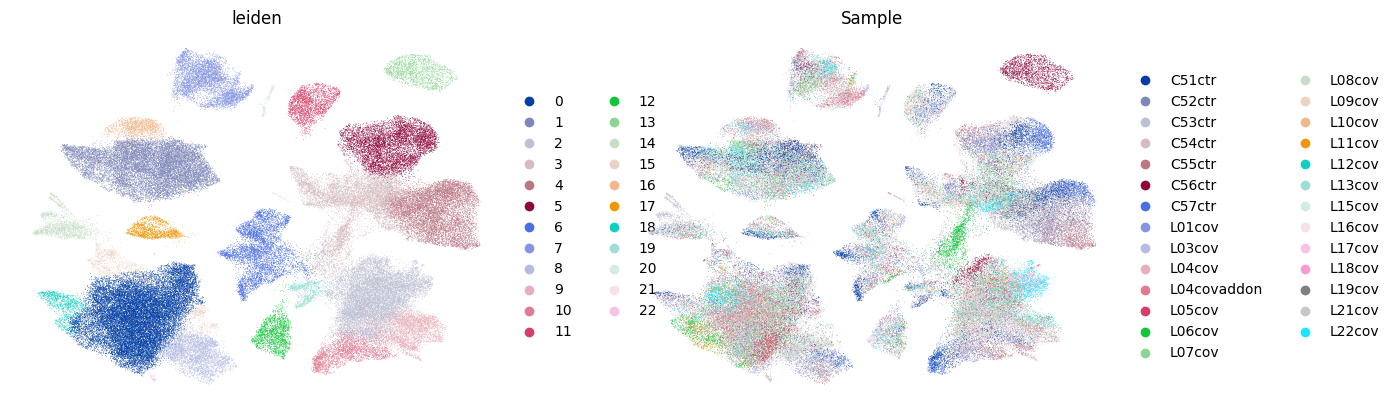

In [7]:
sc.pl.umap(adata, color = ['leiden', 'Sample'], frameon = False)

We found 22 Clusters (at a resolution of 0.5) and have a good intergration as we can see that in the Sample all clusters contain cells from different samples (except for one which seems to be special).

In [ ]:
# I only do this that i do not need to rerun all the time the clustering again when I load the model!
adata.write_h5ad('integratedSC_dataset_clustered.h5ad')

# Cluster Annotation/Label Cell Types

In [1]:
# I started here again because my Kernel crashed. That's why I am reloading the data (luckily I saved the model!). If your data is still in
# the memory you can just continue directly with calling the rank_genes_groups.
import scanpy as sc
import scvi
import seaborn as sns
import numpy as np
import pandas as pd

In [ ]:
from scvi.model import SCVI
model_path = "/Users/thorsten/code/ThorstenCodes/Bioinformatics_TK/Projects/First Single Cell Analysis"
adata = sc.read_h5ad('integratedSC_dataset_clustered.h5ad')
model = SCVI.load(model_path, adata)

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden')

In [ ]:
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

In [3]:
markers = sc.get.rank_genes_groups_df(adata, None)
#Filter for significance
markers = markers[(markers.pvals_adj <0.05) & (markers.logfoldchanges > 0.5)]
markers

KeyError: 'rank_genes_groups'

In [ ]:
marker_scvi = model.differential_expression(groupby = 'leiden')
marker_scvi

DE...:   0%|          | 0/23 [00:00<?, ?it/s]

In [24]:
adata

AnnData object with n_obs × n_vars = 108822 × 21306
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', '_scvi_batch', '_scvi_labels', 'leiden'
    var: 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'log1p', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'Sample_colors', 'rank_genes_groups'
    obsm: 'X_scVI', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs', 'X_umap'
    layers: 'counts', 'scvi_normalized'
    obsp: 'connectivities', 'distances'